### Data Transformation

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter

# Transformations for test and validation data with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize all images to 224x224
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),          # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),            # Randomly flip the image vertically
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Random color jitter
    transforms.ToTensor(),                      # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define transformation (resize and convert to tensor)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()    ,       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



### Setting up dataloaders


#### Creating Dataset with updated transformation


In [3]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import os
data_dir = "/kaggle/input/tumor-trace"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=test_transform)

#### Creating DataLoader

In [24]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# Check the size of each dataset
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 20434
Validation set size: 1989
Test set size: 6851


Number of benign images: 5559
Number of malignant images: 14875


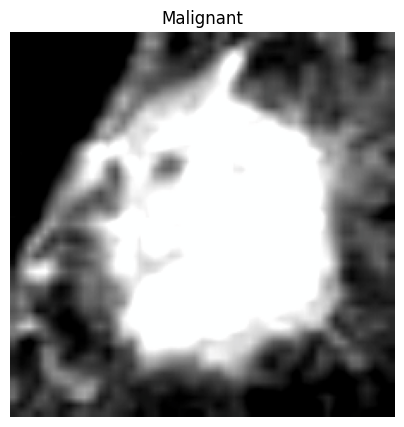

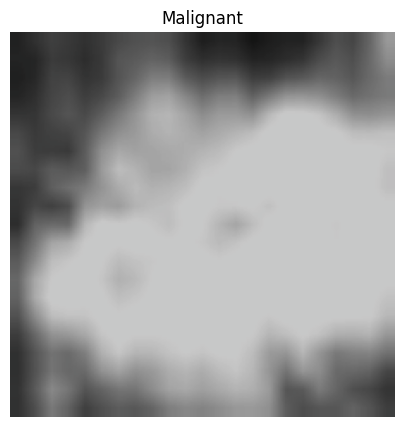

In [25]:
data_dir = "/kaggle/input/tumor-trace"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

# Count number of images in each class in the train  dataset
class_counts = Counter([label for _, label in train_dataset])
print(f"Number of benign images: {class_counts[0]}")
print(f"Number of malignant images: {class_counts[1]}")

# Display two images from the train dataset
labels_map = {0: "Benign", 1: "Malignant"}  # Mapping for labels
images_shown = 0  # Counter to show 2 images

for images, labels in train_loader:
    for i in range(2):  # Display 2 images
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy for displaying
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize the image for visualization
        img = img.clip(0, 1)  # Clip values to be between 0 and 1

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f'{labels_map[labels[i].item()]}')  # Display 'Benign' or 'Malignant'
        plt.axis('off')
        plt.show()

        images_shown += 1
        if images_shown >= 2:
            break
    if images_shown >= 2:
        break

# **Anaylzing the dataset**

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformation (resize and convert to tensor)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Iterate over a batch of images
for images, labels in train_loader:
    # Convert tensor to numpy for displaying
    img = images[0].permute(1, 2, 0).numpy()  # Change dimensions for plotting
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f'Label: {labels[0].item()}')
    plt.axis('off')
    plt.show()
    break  # Display only one image


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Display two images with HOG, Edge Detection, and Corner Detection
images_shown = 0  # Counter to limit to two images

for images, labels in train_loader:
    img = images[0].permute(1, 2, 0).numpy()  # Convert tensor to numpy (H, W, C)

    # Convert to grayscale and scale between 0 and 255
    img = (img * 255).astype(np.uint8).squeeze()

    ### 1. HOG (Histogram of Oriented Gradients) ###
    hog_features, hog_image = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), 
                                  visualize=True, feature_vector=False, block_norm='L2-Hys')
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ### 2. Edge Detection (Canny) ###
    edges = cv2.Canny(img, threshold1=100, threshold2=200)

    ### 3. Corner Detection (Harris Corner Detection) ###
    corners = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)
    corners = cv2.dilate(corners, None)  # Dilate to mark corners
    img_corners = img.copy()
    img_corners[corners > 0.01 * corners.max()] = 255

    ### Display Results ###
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # HOG Features
    plt.subplot(1, 4, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title('HOG Features')
    plt.axis('off')

    # Edge Detection
    plt.subplot(1, 4, 3)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    # Corner Detection
    plt.subplot(1, 4, 4)
    plt.imshow(img_corners, cmap='gray')
    plt.title('Corner Detection')
    plt.axis('off')

    plt.show()

    images_shown += 1
    if images_shown >= 2:  # Stop after displaying 2 images
        break


# **Sobel Edge Detection**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to perform convolution
def convolve(image, kernel):
    image_x, image_y = image.shape  # dimensions (height and width) of the image
    kernel_x, kernel_y = kernel.shape  # dimensions of the kernel

    # Determining the output dimensions
    stride = 1  # step size by which we move the kernel across the image
    padding = 0  # no padding for simplicity

    output_x = int(((image_x - kernel_x + 2 * padding) / stride) + 1)  # dimensions of the output image
    output_y = int(((image_y - kernel_y + 2 * padding) / stride) + 1)

    # Initialize the output feature map
    output = np.zeros((output_x, output_y))  # matrix initialized to zeros to store the convolution result

    # Perform convolution
    for i in range(output_x):
        for j in range(output_y):
            region = image[i:i + kernel_x, j:j + kernel_y]  # extract the region of the image
            output[i, j] = np.sum(region * kernel)  # element-wise multiplication and sum

    return output

# Sobel x operator (horizontal edges)
sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

# Sobel y operator (vertical edges)
sobel_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

# Load the image and convert it to grayscale
image_path = r'/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3p-030.jpg'  # Ensure you provide the correct path to your image
image = Image.open(image_path).convert('L')  # Convert to grayscale
resized_image = image.resize((256, 256))  # Resize the image

# Convert the resized image to a NumPy array
image = np.array(resized_image)

# Apply Sobel x operator
sobel_x_image = convolve(image, sobel_x)

# Apply Sobel y operator
sobel_y_image = convolve(image, sobel_y)

# Calculate the magnitude of gradients
sobel_combined = np.sqrt(sobel_x_image**2 + sobel_y_image**2)

# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sobel_x_image, cmap='gray')
plt.title('Sobel X (Horizontal Edges)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_y_image, cmap='gray')
plt.title('Sobel Y (Vertical Edges)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Combined Edge Detection')
plt.axis('off')

plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_lbp(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    # Iterate over the image excluding border pixels
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]

            lbp_code = 0
            for k in range(8):
                if neighbors[k] >= center:
                    lbp_code |= (1 << k)

            lbp_image[i, j] = lbp_code

    return lbp_image

# Display image inline in Kaggle
def show_image_inline(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    file_path = r'/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate LBP image
    lbp_image = calculate_lbp(image)

    # Display LBP image (for Kaggle environment)
    show_image_inline(lbp_image, title="LBP Image")

    # Save LBP image
    cv2.imwrite('lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_mean_median_variance(image):
    height, width = image.shape
    
    mean_image = np.zeros((height, width), dtype=np.float32)
    median_image = np.zeros((height, width), dtype=np.float32)
    variance_image = np.zeros((height, width), dtype=np.float32)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Extract 3x3 neighborhood
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            
            # Calculate mean, median, and variance
            mean_image[i, j] = np.mean(neighbors)
            median_image[i, j] = np.median(neighbors)
            variance_image[i, j] = np.var(neighbors)
    
    return mean_image, median_image, variance_image

# Display image inline in Kaggle
def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # Update the file path to match your Kaggle dataset structure
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Read the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate mean, median, and variance images
    mean_image, median_image, variance_image = calculate_mean_median_variance(image)

    # Normalize the images for better visualization
    mean_image_normalized = cv2.normalize(mean_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    median_image_normalized = cv2.normalize(median_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    variance_image_normalized = cv2.normalize(variance_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display the mean, median, and variance images inline
    show_image_inline('Mean Image', mean_image_normalized)
    show_image_inline('Median Image', median_image_normalized)
    show_image_inline('Variance Image', variance_image_normalized)

    # Save the mean, median, and variance images
    cv2.imwrite('mean_image.jpg', mean_image_normalized)
    cv2.imwrite('median_image.jpg', median_image_normalized)
    cv2.imwrite('variance_image.jpg', variance_image_normalized)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_mean_lbp_image(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            mean_val = np.mean(neighbors)
            lbp_code = 0

            for k, neighbor in enumerate(neighbors):
                if neighbor >= mean_val:
                    lbp_code |= (1 << k)
            lbp_image[i, j] = lbp_code

    return lbp_image

def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main code
if __name__ == "__main__":
    # Update the file path to match your Kaggle dataset
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_path}")

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate the mean-based LBP image
    lbp_image = calculate_mean_lbp_image(image)

    # Display the LBP image inline
    show_image_inline("Mean LBP Image", lbp_image)

    # Save the LBP image
    cv2.imwrite('mean_lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_median_lbp_image(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            median_val = np.median(neighbors)
            lbp_code = 0

            for k, neighbor in enumerate(neighbors):
                if neighbor >= median_val:
                    lbp_code |= (1 << k)
            lbp_image[i, j] = lbp_code

    return lbp_image

def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main Code
if __name__ == "__main__":
    # Update file path to match your Kaggle dataset structure
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_path}")

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate the median-based LBP image
    lbp_image = calculate_median_lbp_image(image)

    # Display the LBP image inline
    show_image_inline("Median LBP Image", lbp_image)

    # Save the LBP image
    cv2.imwrite('median_lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_variance_lbp_image(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            variance_val = np.var(neighbors)
            lbp_code = 0

            for k, neighbor in enumerate(neighbors):
                if neighbor >= variance_val:
                    lbp_code |= (1 << k)
            lbp_image[i, j] = lbp_code

    return lbp_image

def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main Code
if __name__ == "__main__":
    # Update the file path to match your Kaggle dataset structure
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_path}")

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate the variance-based LBP image
    lbp_image = calculate_variance_lbp_image(image)

    # Display the LBP image inline
    show_image_inline("Variance LBP Image", lbp_image)

    # Save the LBP image
    cv2.imwrite('variance_lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def calculate_horizontal_glcm(image, num_levels=256):
    """
    Manually + for a given grayscale image.
    
    Parameters:
        image (numpy.ndarray): Grayscale input image.
        num_levels (int): Number of gray levels. Default is 256 for 8-bit images.
        
    Returns:
        glcm (numpy.ndarray): Computed GLCM with shape (num_levels, num_levels).
    """
    # Initialize the GLCM matrix with zeros; each cell represents a gray-level pair frequency
    glcm = np.zeros((num_levels, num_levels), dtype=np.int32)

    # Loop through each pixel in the image, except for the last column
    for i in range(image.shape[0]):
        for j in range(image.shape[1] - 1):
            # Current pixel gray-level intensity
            row = image[i, j]
            # Neighbor pixel's gray-level intensity (next pixel in the horizontal direction)
            col = image[i, j + 1]
            # Increment GLCM entry for the observed intensity pair
            glcm[row, col] += 1

    # Normalize the GLCM matrix by dividing each value by the sum of all values, converting it to relative frequencies
    glcm = glcm / glcm.sum()
    return glcm

def show_glcm(glcm, title):
    """
    Display GLCM as a grayscale heatmap for easy visualization of texture information.
    
    Parameters:
        glcm (numpy.ndarray): Computed GLCM matrix.
        title (str): Title of the plot for display purposes.
    """
    plt.figure(figsize=(6, 6))  # Set plot size
    plt.imshow(glcm, cmap='gray')  # Display GLCM as grayscale image
    plt.title(title)  # Add title
    plt.xlabel('Gray Level Intensity of Pixel Pairs')
    plt.ylabel('Gray Level Intensity of Pixel Pairs')
    plt.colorbar(label='Relative Frequency')  # Add color bar to show frequency scale
    plt.show()

# Set the directory where images are stored
image_dir = r'/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3'

# List to store paths of images found in the directory
image_paths = []

# Walk through the directory to collect paths of up to 5 images
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Check for common image file formats
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
        if len(image_paths) >= 5:  # Stop once we have 5 images
            break
    if len(image_paths) >= 5:
        break

# If fewer than 5 images are found, notify the user
if len(image_paths) < 5:
    print("Fewer than 5 images found in the directory.")
else:
    # Process each image path found
    for i, file_path in enumerate(image_paths):
        print(f"Processing image {i + 1}: {file_path}")

        # Load the image in grayscale
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image at {file_path}. Check if file exists and is an image.")
            continue

        # Resize image to a fixed size (optional, for consistent GLCM calculation)
        image = cv2.resize(image, (224, 224))

        # Calculate the horizontal GLCM (considering only horizontally adjacent pixels)
        glcm = calculate_horizontal_glcm(image)
        
        # Display the GLCM as a heatmap for visualization
        show_glcm(glcm, f"GLCM for Image {i + 1} (Horizontal Direction)")


### Setting up the VggCustomMode

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

#Customvgg16 class inherit from nn.Module
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()

        # Loading pre-trained VGG16 model from tourchvision.models
        vgg16 = models.vgg16(pretrained=True)

        # Extracting the features and avgpool layers frm pretrainedmodel
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier nm.Sequential
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), #input and output
            nn.ReLU(inplace=True), #for activation
            nn.Dropout(), #for regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x = self.features(x) # Passing the input through the features layer
        x = self.avgpool(x) # Using the avgpool layer
        x = torch.flatten(x, 1) # Reshaping the output to a 2D tensor
        x = self.classifier(x) # Passing the reshaped output to the custom classifier
        return x

# printing model
if __name__ == "__main__":
    model = CustomVGG16(num_classes=2)
    print(model)
    

CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

**Earlystopping**

In [20]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        self.patience = patience # How long to wait after last time validation loss improved.
        self.verbose = verbose #If true, prints a message for each validation loss improvement. 
        self.delta = delta # Minimum change in monotered quality to quantofy improvement
        self.path = path # file path for saving the model checkpoint
        self.trace_func = trace_func # fun to output message
        self.counter = 0 # track of epochs with no improvement.
        self.best_score = None #store the best score
        self.early_stop = False #indicating whether to stop training.
        self.val_loss_min = np.Inf # store the minimum validation loss encountered during training
        #self.best_epoch = 0 #The epoch number of the best model.
        #Epoch is used to describe one complete pass through the entire training dataset.


    def __call__(self, val_loss, model):
        # method is called at end of each epoch to check if the validation loss has improved.
        score = -val_loss

        if self.best_score is None:
            self.best_score = score #the current score is set as the best score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

# checkpoint methond
    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). save model')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


**Train**

In [21]:
import torch
import torch.nn.functional as F
from tqdm import tqdm


def train(epoch, model, num_epochs, train_loader, criterion, lr_decay, lr, device):
    # Learning rate scheduling
    learning_rate = max(lr * (0.1 ** (epoch // 10)), lr - 5)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lr_decay)
    
    model.train()
    correct = 0
    
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        data = data.float()
        label = label.long()
        
        if device.type == 'cuda':
            data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1)[1]  # Get the index of the max log-probability
        correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()
    
    print(f'Train Epoch: {epoch} \tAccuracy: {100. * correct / len(train_loader.dataset):.2f}%')

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Validation**

In [22]:
#Validation Function

import torch
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc as sklearn_auc
from torch.cuda.amp import GradScaler, autocast

def validation(model, val_dataloader, criterion, device):
    name = 'val'  # change name to test if using for test data
    len_val_dataloader = len(val_dataloader.dataset)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    possibilitys = None

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)

            val_output = model(data)  # Getting model's predictions
            val_loss += F.nll_loss(F.log_softmax(val_output, dim=1), target, reduction='sum').item()  # Calculate the loss
            pred = val_output.data.max(1)[1]  # Get the index of the max log-probability

            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input
            possibility = F.softmax(val_output, dim=1).cpu().data.numpy()  # Softmax is used to convert the range of values in an array between 0-1

            if possibilitys is None:
                possibilitys = possibility
            else:
                possibilitys = np.concatenate((possibilitys, possibility), axis=0)

            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            all_targets.extend(target.cpu().numpy())  # Collect all target labels

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print("Confusion Matrix:\n", cm)

    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilitys.ravel())
    auc_score = sklearn_auc(fpr, tpr)
    
    val_loss /= len(val_dataloader.dataset)
    accuracy = 100. * correct / len(val_dataloader.dataset)

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_score))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            val_loss, correct, len(val_dataloader.dataset), accuracy))

    return accuracy, val_loss, auc_score


## Test

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_auc(fpr, tpr, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Test Function

In [24]:
from sklearn import metrics
import numpy as np
import torch.nn.functional as F

def test(model, test_dataloader, criterion, device):
    name = 'test'
    len_test_dataloader = len(test_dataloader.dataset)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation.
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)

            test_output = model(data)  # Getting model's predictions
            test_loss += criterion(test_output, target).item()  # Calculate the loss
            pred = test_output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input.
            all_targets.extend(target.cpu().numpy())  # Get the true labels
            probabilities = F.softmax(test_output, dim=1).cpu().numpy()  # softmax is used to convert the range of values in an array between 0-1
            all_probabilities.extend(probabilities)

            correct += pred.eq(target.view_as(pred)).sum().item()

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    # Classification metrics - accuracy, f1 score
    classification_rep = metrics.classification_report(all_targets, all_predictions, target_names=['benign', 'malignant'], digits=4)
    print('Classification Report of Test :')
    print(classification_rep)

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print('Confusion Matrix:')
    print(cm)
    plot_confusion_matrix(cm, ['benign', 'malignant'])

    # ROC AUC
    num_classes = all_probabilities.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), all_probabilities.ravel())
    auc_value = metrics.auc(fpr, tpr)
    plot_auc(fpr, tpr, auc_value)

    test_loss /= len_test_dataloader
    accuracy = 100. * correct / len_test_dataloader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(name, test_loss, correct, len_test_dataloader, accuracy))

    return accuracy, test_loss, auc_value


In [16]:
# Check the first batch of data
for data, label in train_loader:
    print(data.shape)  # Should print a tensor shape (batch_size, channels, height, width)
    print(label)  # Should print the labels for this batch
    break


torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1])


In [25]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [26]:

model.to(device)  
model = CustomVGG16(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()
best_accuracy = 0
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
log_interval = 10 
lr_decay = 1e-4
model_name = 'vgg16'

In [33]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# EarlyStopping class should be defined elsewhere in the code
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'vgg16'
model_save_dir = './vgg16'

# Assuming total_epochs, train_loader, val_loader, criterion, lr_decay, lr are defined earlier in the code

# Main training loop
for epoch in range(1, total_epochs + 1):
    # Train the model
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)
   
    # Validation phase
    with torch.no_grad():
        _, test_loss, auc = validation(model, val_loader, criterion, device)

    # Check if model is wrapped in DataParallel or DistributedDataParallel
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Create model save directory if it does not exist
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping based on validation loss
    early_stop(test_loss, model)

    # Save the model if it has the best performance (AUC in this case)
    if auc > best_accuracy:
        best_accuracy = auc
        torch.save(model_state_dict, os.path.join(model_save_dir, f'{model_name}_{epoch}.pth'), _use_new_zipfile_serialization=False)

    # Check for early stopping condition
    if early_stop.early_stop:
        print("Early stopping")
        break


Epoch 2/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 1 	Accuracy: 79.17%


Confusion Matrix:
 [[ 372   36]
 [ 324 1252]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9076

Validation set: Average loss: 0.3878, Accuracy: 1624/1989 (81.65%)

Validation loss decreased (inf --> 0.387811). save model


Epoch 3/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 2 	Accuracy: 85.25%


Confusion Matrix:
 [[ 264  144]
 [ 361 1215]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8505

Validation set: Average loss: 0.4673, Accuracy: 1479/1989 (74.36%)

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 3 	Accuracy: 88.78%


Confusion Matrix:
 [[ 296  112]
 [ 335 1241]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8876

Validation set: Average loss: 0.5175, Accuracy: 1537/1989 (77.28%)

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 4 	Accuracy: 91.22%


Confusion Matrix:
 [[ 279  129]
 [ 342 1234]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8665

Validation set: Average loss: 0.4989, Accuracy: 1513/1989 (76.07%)

EarlyStopping counter: 3 out of 20


Epoch 6/50: 100%|██████████| 638/638 [02:40<00:00,  3.96batch/s]

Train Epoch: 5 	Accuracy: 93.05%


Confusion Matrix:
 [[ 267  141]
 [ 165 1411]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9385

Validation set: Average loss: 0.4067, Accuracy: 1678/1989 (84.36%)

EarlyStopping counter: 4 out of 20


Epoch 7/50: 100%|██████████| 638/638 [02:40<00:00,  3.96batch/s]

Train Epoch: 6 	Accuracy: 94.48%


Confusion Matrix:
 [[ 316   92]
 [ 233 1343]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9283

Validation set: Average loss: 0.3610, Accuracy: 1659/1989 (83.41%)

Validation loss decreased (0.387811 --> 0.361047). save model


Epoch 8/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 7 	Accuracy: 95.36%


Confusion Matrix:
 [[ 283  125]
 [ 195 1381]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9341

Validation set: Average loss: 0.4165, Accuracy: 1664/1989 (83.66%)

EarlyStopping counter: 1 out of 20


Epoch 9/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 8 	Accuracy: 96.42%


Confusion Matrix:
 [[ 262  146]
 [ 176 1400]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9285

Validation set: Average loss: 0.5188, Accuracy: 1662/1989 (83.56%)

EarlyStopping counter: 2 out of 20


Epoch 10/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 9 	Accuracy: 96.77%


Confusion Matrix:
 [[ 260  148]
 [ 170 1406]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9327

Validation set: Average loss: 0.5029, Accuracy: 1666/1989 (83.76%)

EarlyStopping counter: 3 out of 20


Epoch 11/50: 100%|██████████| 638/638 [02:40<00:00,  3.96batch/s]

Train Epoch: 10 	Accuracy: 98.66%


Confusion Matrix:
 [[ 298  110]
 [ 246 1330]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9201

Validation set: Average loss: 0.6962, Accuracy: 1628/1989 (81.85%)

EarlyStopping counter: 4 out of 20


Epoch 12/50: 100%|██████████| 638/638 [02:40<00:00,  3.96batch/s]

Train Epoch: 11 	Accuracy: 99.10%


Confusion Matrix:
 [[ 292  116]
 [ 218 1358]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9230

Validation set: Average loss: 0.7655, Accuracy: 1650/1989 (82.96%)

EarlyStopping counter: 5 out of 20


Epoch 13/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 12 	Accuracy: 99.29%


Confusion Matrix:
 [[ 305  103]
 [ 257 1319]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9098

Validation set: Average loss: 0.9095, Accuracy: 1624/1989 (81.65%)

EarlyStopping counter: 6 out of 20


Epoch 14/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 13 	Accuracy: 99.41%


Confusion Matrix:
 [[ 301  107]
 [ 231 1345]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9216

Validation set: Average loss: 0.9012, Accuracy: 1646/1989 (82.76%)

EarlyStopping counter: 7 out of 20


Epoch 15/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 14 	Accuracy: 99.43%


Confusion Matrix:
 [[ 297  111]
 [ 224 1352]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9233

Validation set: Average loss: 0.8727, Accuracy: 1649/1989 (82.91%)

EarlyStopping counter: 8 out of 20


Epoch 16/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 15 	Accuracy: 99.54%


Confusion Matrix:
 [[ 293  115]
 [ 198 1378]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9313

Validation set: Average loss: 0.9387, Accuracy: 1671/1989 (84.01%)

EarlyStopping counter: 9 out of 20


Epoch 17/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 16 	Accuracy: 99.56%


Confusion Matrix:
 [[ 301  107]
 [ 234 1342]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9161

Validation set: Average loss: 0.9963, Accuracy: 1643/1989 (82.60%)

EarlyStopping counter: 10 out of 20


Epoch 18/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 17 	Accuracy: 99.59%


Confusion Matrix:
 [[ 300  108]
 [ 226 1350]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9260

Validation set: Average loss: 0.9644, Accuracy: 1650/1989 (82.96%)

EarlyStopping counter: 11 out of 20


Epoch 19/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 18 	Accuracy: 99.61%


Confusion Matrix:
 [[ 307  101]
 [ 257 1319]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9103

Validation set: Average loss: 1.1058, Accuracy: 1626/1989 (81.75%)

EarlyStopping counter: 12 out of 20


Epoch 20/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 19 	Accuracy: 99.63%


Confusion Matrix:
 [[ 301  107]
 [ 246 1330]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9107

Validation set: Average loss: 1.1031, Accuracy: 1631/1989 (82.00%)

EarlyStopping counter: 13 out of 20


Epoch 21/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 20 	Accuracy: 99.75%


Confusion Matrix:
 [[ 300  108]
 [ 238 1338]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9153

Validation set: Average loss: 1.0952, Accuracy: 1638/1989 (82.35%)

EarlyStopping counter: 14 out of 20


Epoch 22/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 21 	Accuracy: 99.73%


Confusion Matrix:
 [[ 295  113]
 [ 230 1346]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9186

Validation set: Average loss: 1.0835, Accuracy: 1641/1989 (82.50%)

EarlyStopping counter: 15 out of 20


Epoch 23/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 22 	Accuracy: 99.80%


Confusion Matrix:
 [[ 295  113]
 [ 228 1348]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9197

Validation set: Average loss: 1.0892, Accuracy: 1643/1989 (82.60%)

EarlyStopping counter: 16 out of 20


Epoch 24/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 23 	Accuracy: 99.71%


Confusion Matrix:
 [[ 295  113]
 [ 227 1349]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9197

Validation set: Average loss: 1.1028, Accuracy: 1644/1989 (82.65%)

EarlyStopping counter: 17 out of 20


Epoch 25/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 24 	Accuracy: 99.74%


Confusion Matrix:
 [[ 296  112]
 [ 230 1346]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9187

Validation set: Average loss: 1.1128, Accuracy: 1642/1989 (82.55%)

EarlyStopping counter: 18 out of 20


Epoch 26/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 25 	Accuracy: 99.77%


Confusion Matrix:
 [[ 298  110]
 [ 233 1343]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9181

Validation set: Average loss: 1.1294, Accuracy: 1641/1989 (82.50%)

EarlyStopping counter: 19 out of 20


Epoch 27/50: 100%|██████████| 638/638 [02:41<00:00,  3.96batch/s]

Train Epoch: 26 	Accuracy: 99.76%


Confusion Matrix:
 [[ 296  112]
 [ 229 1347]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9192

Validation set: Average loss: 1.1302, Accuracy: 1643/1989 (82.60%)

EarlyStopping counter: 20 out of 20
Early stopping



 Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.5571    0.3400    0.4223      1938
   malignant     0.7742    0.8933    0.8295      4910

    accuracy                         0.7367      6848
   macro avg     0.6656    0.6167    0.6259      6848
weighted avg     0.7128    0.7367    0.7143      6848

Confusion Matrix:
[[ 659 1279]
 [ 524 4386]]


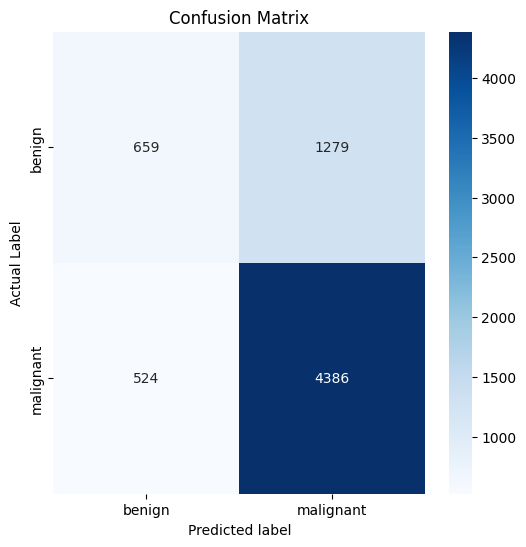

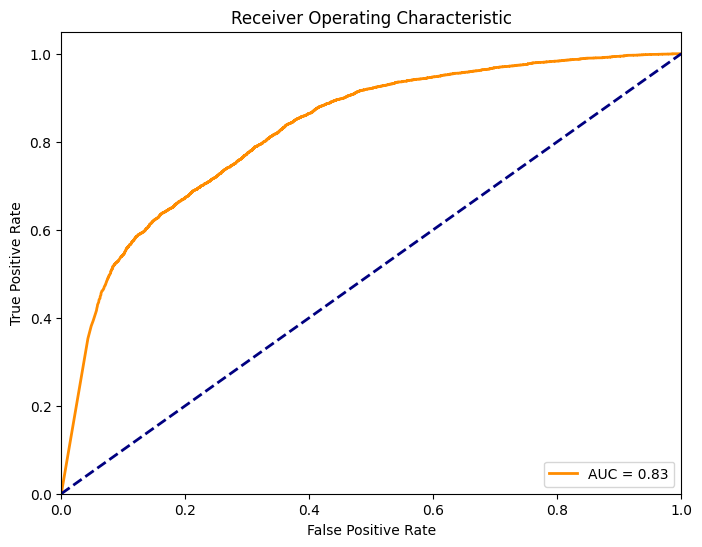

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8257

test set: Average loss: 0.0774, Accuracy: 5045/6851 (73.64%)

Test set results - Accuracy: 73.64%, Loss: 0.0774, AUC: 0.8257


In [38]:
# Test the model
print("\n Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

print(f'Test set results - Accuracy: {test_accuracy:.2f}%, Loss: {test_loss:.4f}, AUC: {test_auc:.4f}')

# **Resnet18** 

In [39]:
class Resnet18(nn.Module):

    def __init__(self, num_classes=2):
        super(Resnet18, self).__init__()

        model_resnet18 = models.resnet18(pretrained=True)

        self.conv1 = model_resnet18.conv1  # convolutional function
        self.bn1 = model_resnet18.bn1  # batch normalization
        self.relu = model_resnet18.relu  # relu is your activation function.
        self.maxpool = model_resnet18.maxpool  # maxpool is basically taking the biggest value per sub-matrix

        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4  # these layers are use for deepening the layers in the architecture which will increase

        self.avgpool = model_resnet18.avgpool
        self._features = model_resnet18.fc.in_features

        self.fc = nn.Linear(self._features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [15]:
model_name = 'resnet18'
model = Resnet18(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [31]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# EarlyStopping class should be defined elsewhere in the code
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'Resnet18'
model_save_dir = './restnet18'

# Assuming total_epochs, train_loader, val_loader, criterion, lr_decay, lr are defined earlier in the code

# Main training loop
for epoch in range(1, total_epochs + 1):
    # Train the model
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)
   
    # Validation phase
    with torch.no_grad():
        _, test_loss, auc = validation(model, val_loader, criterion, device)

    # Check if model is wrapped in DataParallel or DistributedDataParallel
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Create model save directory if it does not exist
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping based on validation loss
    early_stop(test_loss, model)

    # Save the model if it has the best performance (AUC in this case)
    if auc > best_accuracy:
        best_accuracy = auc
        torch.save(model_state_dict, os.path.join(model_save_dir, f'{model_name}_{epoch}.pth'), _use_new_zipfile_serialization=False)

    # Check for early stopping condition
    if early_stop.early_stop:
        print("Early stopping")
        break


Epoch 2/50: 100%|██████████| 638/638 [01:54<00:00,  5.57batch/s]

Train Epoch: 1 	Accuracy: 98.47%


Confusion Matrix:
 [[ 283  125]
 [ 252 1324]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8895

Validation set: Average loss: 0.9744, Accuracy: 1607/1989 (80.79%)

Validation loss decreased (inf --> 0.974408). save model


Epoch 3/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 2 	Accuracy: 98.95%


Confusion Matrix:
 [[ 267  141]
 [ 241 1335]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8753

Validation set: Average loss: 1.2496, Accuracy: 1602/1989 (80.54%)

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 3 	Accuracy: 99.08%


Confusion Matrix:
 [[ 301  107]
 [ 248 1328]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8831

Validation set: Average loss: 1.0537, Accuracy: 1629/1989 (81.90%)

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 4 	Accuracy: 99.24%


Confusion Matrix:
 [[ 258  150]
 [ 177 1399]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9139

Validation set: Average loss: 0.9564, Accuracy: 1657/1989 (83.31%)

Validation loss decreased (0.974408 --> 0.956420). save model


Epoch 6/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 5 	Accuracy: 99.14%


Confusion Matrix:
 [[ 284  124]
 [ 201 1375]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9033

Validation set: Average loss: 1.1538, Accuracy: 1659/1989 (83.41%)

EarlyStopping counter: 1 out of 20


Epoch 7/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 6 	Accuracy: 99.54%


Confusion Matrix:
 [[ 288  120]
 [ 245 1331]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8814

Validation set: Average loss: 1.4184, Accuracy: 1619/1989 (81.40%)

EarlyStopping counter: 2 out of 20


Epoch 8/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 7 	Accuracy: 99.19%


Confusion Matrix:
 [[ 265  143]
 [ 311 1265]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8783

Validation set: Average loss: 1.1724, Accuracy: 1530/1989 (76.92%)

EarlyStopping counter: 3 out of 20


Epoch 9/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 8 	Accuracy: 99.27%


Confusion Matrix:
 [[ 284  124]
 [ 236 1340]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8970

Validation set: Average loss: 1.0129, Accuracy: 1624/1989 (81.65%)

EarlyStopping counter: 4 out of 20


Epoch 10/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 9 	Accuracy: 99.46%


Confusion Matrix:
 [[ 287  121]
 [ 262 1314]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8695

Validation set: Average loss: 1.3415, Accuracy: 1601/1989 (80.49%)

EarlyStopping counter: 5 out of 20


Epoch 11/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 10 	Accuracy: 99.71%


Confusion Matrix:
 [[ 286  122]
 [ 223 1353]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8911

Validation set: Average loss: 1.3077, Accuracy: 1639/1989 (82.40%)

EarlyStopping counter: 6 out of 20


Epoch 12/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 11 	Accuracy: 99.80%


Confusion Matrix:
 [[ 268  140]
 [ 182 1394]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9004

Validation set: Average loss: 1.2325, Accuracy: 1662/1989 (83.56%)

EarlyStopping counter: 7 out of 20


Epoch 13/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 12 	Accuracy: 99.79%


Confusion Matrix:
 [[ 296  112]
 [ 217 1359]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8960

Validation set: Average loss: 1.1929, Accuracy: 1655/1989 (83.21%)

EarlyStopping counter: 8 out of 20


Epoch 14/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 13 	Accuracy: 99.86%


Confusion Matrix:
 [[ 283  125]
 [ 222 1354]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8916

Validation set: Average loss: 1.2569, Accuracy: 1637/1989 (82.30%)

EarlyStopping counter: 9 out of 20


Epoch 15/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 14 	Accuracy: 99.86%


Confusion Matrix:
 [[ 275  133]
 [ 204 1372]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8972

Validation set: Average loss: 1.3082, Accuracy: 1647/1989 (82.81%)

EarlyStopping counter: 10 out of 20


Epoch 16/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 15 	Accuracy: 99.87%


Confusion Matrix:
 [[ 285  123]
 [ 203 1373]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8966

Validation set: Average loss: 1.3079, Accuracy: 1658/1989 (83.36%)

EarlyStopping counter: 11 out of 20


Epoch 17/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 16 	Accuracy: 99.89%


Confusion Matrix:
 [[ 294  114]
 [ 230 1346]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8868

Validation set: Average loss: 1.3877, Accuracy: 1640/1989 (82.45%)

EarlyStopping counter: 12 out of 20


Epoch 18/50: 100%|██████████| 638/638 [01:54<00:00,  5.59batch/s]

Train Epoch: 17 	Accuracy: 99.89%


Confusion Matrix:
 [[ 292  116]
 [ 215 1361]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8860

Validation set: Average loss: 1.3758, Accuracy: 1653/1989 (83.11%)

EarlyStopping counter: 13 out of 20


Epoch 19/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 18 	Accuracy: 99.87%


Confusion Matrix:
 [[ 286  122]
 [ 211 1365]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8889

Validation set: Average loss: 1.3830, Accuracy: 1651/1989 (83.01%)

EarlyStopping counter: 14 out of 20


Epoch 20/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 19 	Accuracy: 99.88%


Confusion Matrix:
 [[ 280  128]
 [ 194 1382]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8937

Validation set: Average loss: 1.4020, Accuracy: 1662/1989 (83.56%)

EarlyStopping counter: 15 out of 20


Epoch 21/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 20 	Accuracy: 99.88%


Confusion Matrix:
 [[ 270  138]
 [ 181 1395]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8994

Validation set: Average loss: 1.3870, Accuracy: 1665/1989 (83.71%)

EarlyStopping counter: 16 out of 20


Epoch 22/50: 100%|██████████| 638/638 [01:54<00:00,  5.59batch/s]

Train Epoch: 21 	Accuracy: 99.88%


Confusion Matrix:
 [[ 266  142]
 [ 173 1403]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9006

Validation set: Average loss: 1.4105, Accuracy: 1669/1989 (83.91%)

EarlyStopping counter: 17 out of 20


Epoch 23/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 22 	Accuracy: 99.88%


Confusion Matrix:
 [[ 289  119]
 [ 208 1368]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8907

Validation set: Average loss: 1.4106, Accuracy: 1657/1989 (83.31%)

EarlyStopping counter: 18 out of 20


Epoch 24/50: 100%|██████████| 638/638 [01:54<00:00,  5.59batch/s]

Train Epoch: 23 	Accuracy: 99.87%


Confusion Matrix:
 [[ 288  120]
 [ 208 1368]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8905

Validation set: Average loss: 1.4621, Accuracy: 1656/1989 (83.26%)

EarlyStopping counter: 19 out of 20


Epoch 25/50: 100%|██████████| 638/638 [01:54<00:00,  5.59batch/s]

Train Epoch: 24 	Accuracy: 99.88%


Confusion Matrix:
 [[ 280  128]
 [ 205 1371]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8911

Validation set: Average loss: 1.4247, Accuracy: 1651/1989 (83.01%)

EarlyStopping counter: 20 out of 20
Early stopping



 Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.5936    0.3369    0.4299      1938
   malignant     0.7764    0.9090    0.8375      4910

    accuracy                         0.7471      6848
   macro avg     0.6850    0.6230    0.6337      6848
weighted avg     0.7247    0.7471    0.7221      6848

Confusion Matrix:
[[ 653 1285]
 [ 447 4463]]


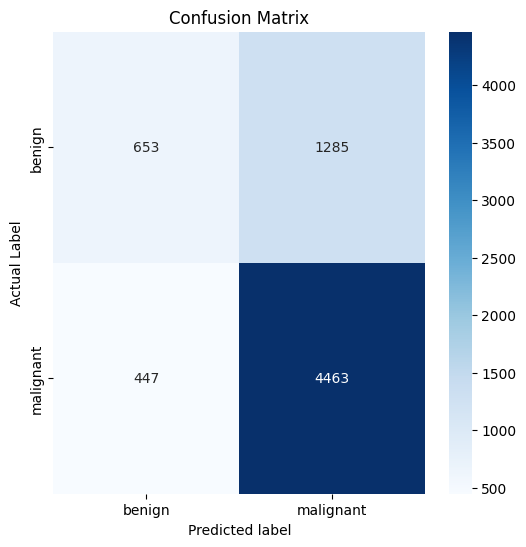

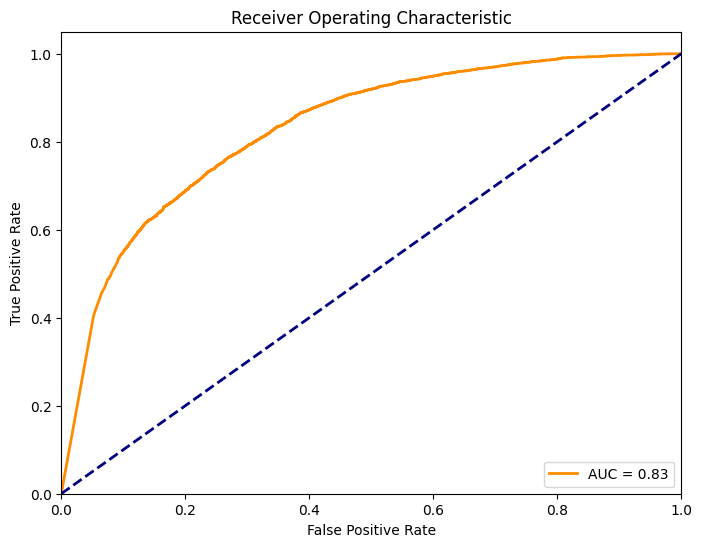

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8305

test set: Average loss: 0.0834, Accuracy: 5116/6851 (74.68%)

Test set results - Accuracy: 74.68%, Loss: 0.0834, AUC: 0.8305


In [41]:
# Test the model
print("\n Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

print(f'Test set results - Accuracy: {test_accuracy:.2f}%, Loss: {test_loss:.4f}, AUC: {test_auc:.4f}')

# **Resnet50**

In [27]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()

        model_resnet50 = models.resnet50(pretrained=True)

        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool

        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4

        self.avgpool = model_resnet50.avgpool
        self._features = model_resnet50.fc.in_features

        self.fc = nn.Linear(self._features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [28]:
model_name = 'resnet50'
model = Resnet50(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [29]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# EarlyStopping class should be defined elsewhere in the code
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'Resnet50'
model_save_dir = './restnet50'

# Assuming total_epochs, train_loader, val_loader, criterion, lr_decay, lr are defined earlier in the code

# Main training loop
for epoch in range(1, total_epochs + 1):
    # Train the model
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)
   
    # Validation phase
    with torch.no_grad():
        _, test_loss, auc = validation(model, val_loader, criterion, device)

    # Check if model is wrapped in DataParallel or DistributedDataParallel
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Create model save directory if it does not exist
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping based on validation loss
    early_stop(test_loss, model)

    # Save the model if it has the best performance (AUC in this case)
    if auc > best_accuracy:
        best_accuracy = auc
        torch.save(model_state_dict, os.path.join(model_save_dir, f'{model_name}_{epoch}.pth'), _use_new_zipfile_serialization=False)

    # Check for early stopping condition
    if early_stop.early_stop:
        print("Early stopping")
        break


Epoch 2/50: 100%|██████████| 638/638 [01:55<00:00,  5.54batch/s]

Train Epoch: 1 	Accuracy: 80.33%


Confusion Matrix:
 [[ 349   59]
 [ 439 1137]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8298

Validation set: Average loss: 0.5285, Accuracy: 1486/1989 (74.71%)

Validation loss decreased (inf --> 0.528521). save model


Epoch 3/50: 100%|██████████| 638/638 [01:54<00:00,  5.59batch/s]

Train Epoch: 2 	Accuracy: 88.46%


Confusion Matrix:
 [[ 299  109]
 [ 255 1321]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9157

Validation set: Average loss: 0.3722, Accuracy: 1620/1989 (81.45%)

Validation loss decreased (0.528521 --> 0.372212). save model


Epoch 4/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 3 	Accuracy: 92.44%


Confusion Matrix:
 [[ 225  183]
 [ 189 1387]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9097

Validation set: Average loss: 0.5565, Accuracy: 1612/1989 (81.05%)

EarlyStopping counter: 1 out of 20


Epoch 5/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 4 	Accuracy: 94.85%


Confusion Matrix:
 [[ 265  143]
 [ 242 1334]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9055

Validation set: Average loss: 0.4882, Accuracy: 1599/1989 (80.39%)

EarlyStopping counter: 2 out of 20


Epoch 6/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 5 	Accuracy: 96.31%


Confusion Matrix:
 [[ 289  119]
 [ 219 1357]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9018

Validation set: Average loss: 0.6680, Accuracy: 1646/1989 (82.76%)

EarlyStopping counter: 3 out of 20


Epoch 7/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 6 	Accuracy: 97.19%


Confusion Matrix:
 [[ 300  108]
 [ 257 1319]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9186

Validation set: Average loss: 0.6461, Accuracy: 1619/1989 (81.40%)

EarlyStopping counter: 4 out of 20


Epoch 8/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 7 	Accuracy: 97.95%


Confusion Matrix:
 [[ 219  189]
 [ 180 1396]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8914

Validation set: Average loss: 0.9085, Accuracy: 1615/1989 (81.20%)

EarlyStopping counter: 5 out of 20


Epoch 9/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 8 	Accuracy: 98.28%


Confusion Matrix:
 [[ 237  171]
 [ 152 1424]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9338

Validation set: Average loss: 0.7322, Accuracy: 1661/1989 (83.51%)

EarlyStopping counter: 6 out of 20


Epoch 10/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 9 	Accuracy: 98.51%


Confusion Matrix:
 [[ 269  139]
 [ 198 1378]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9086

Validation set: Average loss: 0.9628, Accuracy: 1647/1989 (82.81%)

EarlyStopping counter: 7 out of 20


Epoch 11/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 10 	Accuracy: 99.47%


Confusion Matrix:
 [[ 263  145]
 [ 200 1376]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8951

Validation set: Average loss: 1.1019, Accuracy: 1639/1989 (82.40%)

EarlyStopping counter: 8 out of 20


Epoch 12/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 11 	Accuracy: 99.52%


Confusion Matrix:
 [[ 258  150]
 [ 189 1387]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8957

Validation set: Average loss: 1.2189, Accuracy: 1645/1989 (82.70%)

EarlyStopping counter: 9 out of 20


Epoch 13/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 12 	Accuracy: 99.65%


Confusion Matrix:
 [[ 273  135]
 [ 213 1363]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8947

Validation set: Average loss: 1.2364, Accuracy: 1636/1989 (82.25%)

EarlyStopping counter: 10 out of 20


Epoch 14/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 13 	Accuracy: 99.61%


Confusion Matrix:
 [[ 258  150]
 [ 189 1387]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8985

Validation set: Average loss: 1.2447, Accuracy: 1645/1989 (82.70%)

EarlyStopping counter: 11 out of 20


Epoch 15/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 14 	Accuracy: 99.75%


Confusion Matrix:
 [[ 273  135]
 [ 214 1362]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8899

Validation set: Average loss: 1.3605, Accuracy: 1635/1989 (82.20%)

EarlyStopping counter: 12 out of 20


Epoch 16/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 15 	Accuracy: 99.72%


Confusion Matrix:
 [[ 276  132]
 [ 211 1365]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8904

Validation set: Average loss: 1.3698, Accuracy: 1641/1989 (82.50%)

EarlyStopping counter: 13 out of 20


Epoch 17/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 16 	Accuracy: 99.69%


Confusion Matrix:
 [[ 276  132]
 [ 224 1352]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8869

Validation set: Average loss: 1.3824, Accuracy: 1628/1989 (81.85%)

EarlyStopping counter: 14 out of 20


Epoch 18/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 17 	Accuracy: 99.76%


Confusion Matrix:
 [[ 275  133]
 [ 217 1359]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8843

Validation set: Average loss: 1.4821, Accuracy: 1634/1989 (82.15%)

EarlyStopping counter: 15 out of 20


Epoch 19/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 18 	Accuracy: 99.77%


Confusion Matrix:
 [[ 275  133]
 [ 207 1369]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8884

Validation set: Average loss: 1.4640, Accuracy: 1644/1989 (82.65%)

EarlyStopping counter: 16 out of 20


Epoch 20/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 19 	Accuracy: 99.80%


Confusion Matrix:
 [[ 265  143]
 [ 193 1383]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8951

Validation set: Average loss: 1.4612, Accuracy: 1648/1989 (82.86%)

EarlyStopping counter: 17 out of 20


Epoch 21/50: 100%|██████████| 638/638 [01:53<00:00,  5.60batch/s]

Train Epoch: 20 	Accuracy: 99.77%


Confusion Matrix:
 [[ 267  141]
 [ 198 1378]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8966

Validation set: Average loss: 1.4341, Accuracy: 1645/1989 (82.70%)

EarlyStopping counter: 18 out of 20


Epoch 22/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 21 	Accuracy: 99.82%


Confusion Matrix:
 [[ 260  148]
 [ 190 1386]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9000

Validation set: Average loss: 1.4620, Accuracy: 1646/1989 (82.76%)

EarlyStopping counter: 19 out of 20


Epoch 23/50: 100%|██████████| 638/638 [01:53<00:00,  5.61batch/s]

Train Epoch: 22 	Accuracy: 99.82%


Confusion Matrix:
 [[ 271  137]
 [ 207 1369]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8938

Validation set: Average loss: 1.4271, Accuracy: 1640/1989 (82.45%)

EarlyStopping counter: 20 out of 20
Early stopping



 Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.5738    0.4752    0.5199      1938
   malignant     0.8060    0.8607    0.8325      4910

    accuracy                         0.7516      6848
   macro avg     0.6899    0.6680    0.6762      6848
weighted avg     0.7403    0.7516    0.7440      6848

Confusion Matrix:
[[ 921 1017]
 [ 684 4226]]


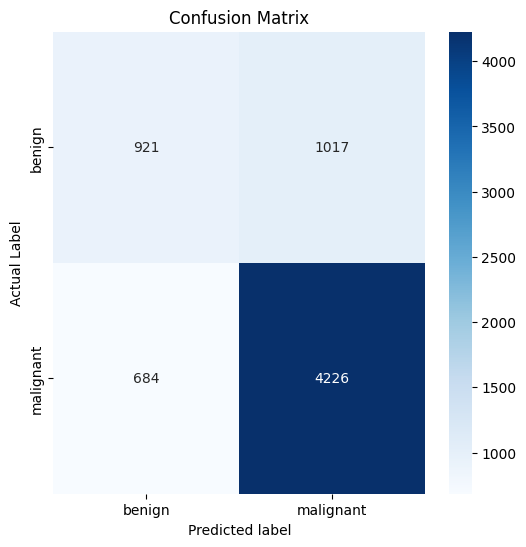

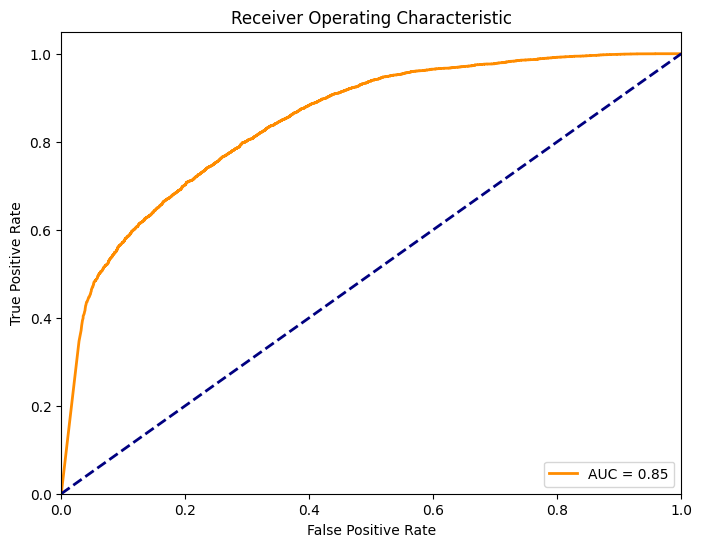

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8458

test set: Average loss: 0.0615, Accuracy: 5147/6851 (75.13%)

Test set results - Accuracy: 75.13%, Loss: 0.0615, AUC: 0.8458


In [30]:
# Test the model
print("\n Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

print(f'Test set results - Accuracy: {test_accuracy:.2f}%, Loss: {test_loss:.4f}, AUC: {test_auc:.4f}')